In [9]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
import os
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [10]:
fileName = "C:/Users/Aren Kabarajian/Downloads/usa_00012.csv"
# fileName = "C:/Users/akaba/Downloads/usa_00012.csv"
file = pd.read_csv(fileName)
dfCDI = pd.DataFrame(file)

In [11]:
def dummy(df, _g):
    return df.assign(**{_g: 'Total'})

In [12]:
dfCDI.shape

(6787855, 40)

In [13]:
dfCDI.columns

Index(['YEAR', 'MULTYEAR', 'SAMPLE', 'SERIAL', 'CBSERIAL', 'HHWT', 'CLUSTER',
       'CPI99', 'STATEFIP', 'COUNTYFIP', 'DENSITY', 'CITY', 'PUMA', 'STRATA',
       'GQ', 'OWNERSHP', 'OWNERSHPD', 'OWNCOST', 'RENTGRS', 'HHINCOME',
       'CIHISPEED', 'PERNUM', 'PERWT', 'FAMSIZE', 'SEX', 'AGE', 'RACE',
       'RACED', 'HISPAN', 'HISPAND', 'EDUC', 'EDUCD', 'OCCSOC', 'INDNAICS',
       'INCTOT', 'FTOTINC', 'INCWAGE', 'MIGCOUNTY1', 'MOVEDIN', 'TRANTIME'],
      dtype='object')

In [14]:
dfCDI = dfCDI[dfCDI['AGE']>=21]
dfCDI.shape

(4823667, 40)

In [15]:
dfHomeOwn=dfCDI[dfCDI['OWNERSHP']==1]
dfHomeOwn.RENTGRS.describe()

count    2964818.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: RENTGRS, dtype: float64

In [16]:
dfCDI = dfCDI[dfCDI['OWNERSHP']!=0]
dfCDI.shape

(4677699, 40)

In [17]:
dfCDI['affrentdec'] = dfCDI['RENTGRS']*12/dfCDI['HHINCOME']

In [18]:
def housingFunc(own, affrentdec):
    if own==1:
        housingCat=2
    elif own==2 and affrentdec<.3:
        housingCat=1
    else:
        housingCat=0
    return housingCat

In [19]:
dfCDI['HousingCat'] = dfCDI.apply(lambda x: housingFunc(x['OWNERSHP'], x['affrentdec']), axis=1)
dfCDI['HousingCat'].value_counts()

2    2964818
1     968222
0     744659
Name: HousingCat, dtype: int64

In [20]:
dfCDI['EDUCbin'] = [1 if x >=8 else 0 for x in dfCDI['EDUC']]
dfCDI['EDUCbin'].value_counts()

0    2937721
1    1739978
Name: EDUCbin, dtype: int64

In [21]:
dfCDI['TRANTIME'].value_counts()

0      1988964
30      394673
15      393749
20      378805
10      319484
        ...   
119          3
118          3
123          3
117          3
126          1
Name: TRANTIME, Length: 133, dtype: int64

## Split by year

In [22]:
dfCDI['YEAR'].value_counts()

2019    1358004
2010    1219545
2000    1119919
1990     980231
Name: YEAR, dtype: int64

In [23]:
df19=dfCDI[dfCDI['YEAR']==2019]
df10=dfCDI[dfCDI['YEAR']==2010]
df00=dfCDI[dfCDI['YEAR']==2000]
df90=dfCDI[dfCDI['YEAR']==1990]

In [24]:
print(dfCDI.columns.get_loc("HousingCat"))
print(dfCDI.columns.get_loc("EDUCbin"))
print(dfCDI.columns.get_loc("TRANTIME"))
print(dfCDI.columns.get_loc("HHWT"))
print(dfCDI.columns.get_loc("HHINCOME"))
print(dfCDI.columns.get_loc("RACE"))
print(dfCDI.columns.get_loc("AGE"))
print(dfCDI.columns.get_loc("SEX"))
print(dfCDI.columns.get_loc("COUNTYFIP"))
print(dfCDI.columns.get_loc("HISPAN"))

41
42
39
5
19
26
25
24
9
28


In [25]:
x19 = df19.iloc[:, [41,42,39,5,19,26,25,24,9,28]]
x10 = df10.iloc[:, [41,42,39,5,19,26,25,24,9,28]]
x00 = df00.iloc[:, [41,42,39,5,19,26,25,24,9,28]]
x90 = df90.iloc[:, [41,42,39,5,19,26,25,24,9,28]]

## Scaling Values

In [26]:

scaler = StandardScaler()
scalerNum = scaler.fit(x19)
scalerNum1 = scaler.fit(x10)
scalerNum2 = scaler.fit(x00)
scalerNum3 = scaler.fit(x90)
xstd19 = scalerNum.transform(x19)
xstd10 = scalerNum1.transform(x10)
xstd00 = scalerNum2.transform(x00)
xstd90 = scalerNum3.transform(x90)

In [27]:
dfX19 = pd.DataFrame(xstd19, columns=['HousingCat','EDUCbin','TRANTIME','HHWT','HHINCOME','RACE','AGE','SEX','COUNTYFIP','HISPAN'])
dfX10 = pd.DataFrame(xstd10, columns=['HousingCat','EDUCbin','TRANTIME','HHWT','HHINCOME','RACE','AGE','SEX','COUNTYFIP','HISPAN'])
dfX00 = pd.DataFrame(xstd00, columns=['HousingCat','EDUCbin','TRANTIME','HHWT','HHINCOME','RACE','AGE','SEX','COUNTYFIP','HISPAN'])
dfX90 = pd.DataFrame(xstd90, columns=['HousingCat','EDUCbin','TRANTIME','HHWT','HHINCOME','RACE','AGE','SEX','COUNTYFIP','HISPAN'])

## Sillouette Score 

In [28]:
#2019
for i in range(2,8):
    km = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    cluster_labels = km.fit_predict(dfX19.iloc[:,0:3])
    silhouette_avg = silhouette_score(dfX19.iloc[:,0:3], cluster_labels, metric='euclidean',sample_size = 10000, random_state=None)
    print('For n_clusters = {} the average silhouette_score is: {}'.format(i, silhouette_avg))

For n_clusters = 2 the average silhouette_score is: 0.40664260024935905
For n_clusters = 3 the average silhouette_score is: 0.43907460219146105
For n_clusters = 4 the average silhouette_score is: 0.5011968850360216
For n_clusters = 5 the average silhouette_score is: 0.5411738617945244
For n_clusters = 6 the average silhouette_score is: 0.5423355209244111
For n_clusters = 7 the average silhouette_score is: 0.5688367578091778


In [29]:
#2010 
for i in range(2,8):
    km = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    cluster_labels = km.fit_predict(dfX10.iloc[:,0:3])
    silhouette_avg = silhouette_score(dfX10.iloc[:,0:3], cluster_labels, metric='euclidean', sample_size = 10000, random_state=None)
    print('For n_clusters = {} the average silhouette_score is: {}'.format(i, silhouette_avg))

For n_clusters = 2 the average silhouette_score is: 0.4286865427543697
For n_clusters = 3 the average silhouette_score is: 0.4874280086412589
For n_clusters = 4 the average silhouette_score is: 0.5298472273070853
For n_clusters = 5 the average silhouette_score is: 0.559694334652719
For n_clusters = 6 the average silhouette_score is: 0.577275888169961
For n_clusters = 7 the average silhouette_score is: 0.584535155464788


In [30]:
#2000 
for i in range(2,8):
    km = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    cluster_labels = km.fit_predict(dfX00.iloc[:,0:3])
    silhouette_avg = silhouette_score(dfX00.iloc[:,0:3], cluster_labels, metric='euclidean',sample_size = 10000, random_state=None)
    print('For n_clusters = {} the average silhouette_score is: {}'.format(i, silhouette_avg))

For n_clusters = 2 the average silhouette_score is: 0.42083205919124966
For n_clusters = 3 the average silhouette_score is: 0.46436634983647346
For n_clusters = 4 the average silhouette_score is: 0.5105628552603575
For n_clusters = 5 the average silhouette_score is: 0.5203164267279404
For n_clusters = 6 the average silhouette_score is: 0.546599675104996
For n_clusters = 7 the average silhouette_score is: 0.5601675907834844


In [31]:
#1990 
for i in range(2,8):
    km = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    cluster_labels = km.fit_predict(dfX90.iloc[:,0:3])
    silhouette_avg = silhouette_score(dfX90.iloc[:,0:3], cluster_labels, metric='euclidean',sample_size = 10000, random_state=None)
    print('For n_clusters = {} the average silhouette_score is: {}'.format(i, silhouette_avg))

For n_clusters = 2 the average silhouette_score is: 0.4401597336436821
For n_clusters = 3 the average silhouette_score is: 0.4849761273767745
For n_clusters = 4 the average silhouette_score is: 0.5191793036729798
For n_clusters = 5 the average silhouette_score is: 0.5447497925250794
For n_clusters = 6 the average silhouette_score is: 0.5554422177789348
For n_clusters = 7 the average silhouette_score is: 0.5798048251749377


## Clustering

### 2019

In [32]:
@means
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
kmeans.fit(dfX19.iloc[:,0:3])
X19fin = scaler.inverse_transform(dfX19)
dfX19fin = pd.DataFrame(X19fin, columns=['HousingCat','EDUCbin','TRANTIME','HHWT','HHINCOME','RACE','AGE','SEX','COUNTYFIP','HISPAN'])
dfX19fin['labels'] = kmeans.labels_
cluster_sum19 = dfX19fin.groupby(by = 'labels').mean()
cluster_sum19.head(4)


,HousingCat,EDUCbin,TRANTIME,HHWT,HHINCOME,RACE,AGE,SEX,COUNTYFIP,HISPAN
labels,,,,,,,,,,
0,1.543045,0.550659,65.664992,19.344140,154190.587186,2.887467,43.88133,1.412457,50.737520,0.521153
1,2.000000,0.000000,8.273124,17.909909,107457.346604,2.579474,55.07378,1.536620,53.620485,0.529275
2,0.372773,0.174701,10.697424,22.878139,60155.983985,3.014674,45.19806,1.539046,52.058714,0.691835
3,1.798516,1.000000,11.239513,17.946414,172412.838064,2.441328,51.33839,1.535730,54.937545,0.232373


In [46]:
#median table
dfX19fin.groupby(by = 'labels').median()

,HousingCat,EDUCbin,TRANTIME,HHWT,HHINCOME,RACE,AGE,SEX,COUNTYFIP,HISPAN
labels,,,,,,,,,,
0,2.0,1.0,6.000000e+01,15.0,122517.0,1.0,43.0,1.0,41.0,0.0
1,2.0,0.0,1.776357e-15,14.0,85000.0,1.0,57.0,2.0,59.0,0.0
2,0.0,0.0,5.000000e+00,18.0,47000.0,1.0,42.0,2.0,47.0,0.0
3,2.0,1.0,8.000000e+00,14.0,132661.0,1.0,51.0,2.0,59.0,0.0


In [33]:
#seperate Clusters
clust2019_0 = dfX19fin[dfX19fin['labels']==0]
clust2019_1 = dfX19fin[dfX19fin['labels']==1]
clust2019_2 = dfX19fin[dfX19fin['labels']==2]
clust2019_3 = dfX19fin[dfX19fin['labels']==3]

In [34]:
hhTotal0_2019=clust2019_0['HHWT'].sum()
hhTotal1_2019=clust2019_1['HHWT'].sum()
hhTotal2_2019=clust2019_2['HHWT'].sum()
hhTotal3_2019=clust2019_3['HHWT'].sum()

In [35]:
clust2019_0['RowWt'] = clust2019_0['HHWT']/hhTotal0_2019
clust2019_1['RowWt'] = clust2019_1['HHWT']/hhTotal1_2019
clust2019_2['RowWt'] = clust2019_2['HHWT']/hhTotal2_2019
clust2019_3['RowWt'] = clust2019_3['HHWT']/hhTotal3_2019

C:\Users\Aren Kabarajian\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Aren Kabarajian\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Aren Kabarajian\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [36]:
#VIZ

In [37]:

clustNames= ['Cluster 0', 'Cluster 1', 'Cluster 2','Cluster 3',]
dfHousing_2019 = pd.DataFrame(index=clustNames, data=np.array([[clust2019_0.loc[clust2019_0['HousingCat']==0].RowWt.sum(),
                                                     clust2019_0.loc[clust2019_0['HousingCat']==1].RowWt.sum(),
                                                     clust2019_0.loc[clust2019_0['HousingCat']==2].RowWt.sum()], 
                                                    [clust2019_1.loc[clust2019_1['HousingCat']==0].RowWt.sum(),
                                                     clust2019_1.loc[clust2019_1['HousingCat']==1].RowWt.sum(),
                                                     clust2019_1.loc[clust2019_1['HousingCat']==2].RowWt.sum()],
                                                    [clust2019_2.loc[clust2019_2['HousingCat']==0].RowWt.sum(),
                                                     clust2019_2.loc[clust2019_2['HousingCat']==1].RowWt.sum(),
                                                     clust2019_2.loc[clust2019_2['HousingCat']==2].RowWt.sum()],
                                                    [clust2019_3.loc[clust2019_3['HousingCat']==0].RowWt.sum(),
                                                     clust2019_3.loc[clust2019_3['HousingCat']==1].RowWt.sum(),
                                                     clust2019_3.loc[clust2019_3['HousingCat']==2].RowWt.sum()],
                                                    ]),
                   columns=['>=30% Income on Rent', '<30% Income on Rent', 'Owner'])
dfHousing_2019

,>=30% Income on Rent,<30% Income on Rent,Owner
Cluster 0,0.117737,0.283165,0.599098
Cluster 1,0.000000,0.000000,1.000000
Cluster 2,0.631663,0.368337,0.000000
Cluster 3,0.000000,0.237136,0.762864


In [30]:

clustNames= ['Cluster 0', 'Cluster 1', 'Cluster 2','Cluster 3',]
dfEDU_2019 = pd.DataFrame(index=clustNames, data=np.array([[clust2019_0.loc[clust2019_0['EDUCbin']==0].RowWt.sum(),
                                                     clust2019_0.loc[clust2019_0['EDUCbin']==1].RowWt.sum()], 
                                                    [clust2019_1.loc[clust2019_1['EDUCbin']==0].RowWt.sum(),
                                                     clust2019_1.loc[clust2019_1['EDUCbin']==1].RowWt.sum()],
                                                    [clust2019_2.loc[clust2019_2['EDUCbin']==0].RowWt.sum(),
                                                     clust2019_2.loc[clust2019_2['EDUCbin']==1].RowWt.sum()],
                                                    [clust2019_3.loc[clust2019_3['EDUCbin']==0].RowWt.sum(),
                                                     clust2019_3.loc[clust2019_3['EDUCbin']==1].RowWt.sum(),
                                                    ]]),
                   columns=['<2 yr. College', '>2 yr. College'])
dfEDU_2019

,<2 yr. College,>2 yr. College
Cluster 0,0.000000,1.000000
Cluster 1,0.732596,0.267404
Cluster 2,0.550536,0.449464
Cluster 3,1.000000,0.000000


In [39]:
clustNames= ['Cluster 0', 'Cluster 1', 'Cluster 2','Cluster 3']
dfR19 = pd.DataFrame(index=clustNames, data=np.array([[clust2019_0.loc[clust2019_0['RACE']==1].RowWt.sum(),clust2019_0.loc[clust2019_0['RACE']==2].RowWt.sum(),clust2019_0.loc[clust2019_0['RACE']==3].RowWt.sum(),
                                                    clust2019_0.loc[clust2019_0['RACE']==4].RowWt.sum(),clust2019_0.loc[clust2019_0['RACE']==5].RowWt.sum(),clust2019_0.loc[clust2019_0['RACE']==6].RowWt.sum(),
                                                    clust2019_0.loc[clust2019_0['RACE']==7].RowWt.sum(),clust2019_0.loc[clust2019_0['RACE']==8].RowWt.sum(),clust2019_0.loc[clust2019_0['RACE']==9].RowWt.sum()], 
                                                    [clust2019_1.loc[clust2019_1['RACE']==1].RowWt.sum(),clust2019_1.loc[clust2019_1['RACE']==2].RowWt.sum(),clust2019_1.loc[clust2019_1['RACE']==3].RowWt.sum(),
                                                    clust2019_1.loc[clust2019_1['RACE']==4].RowWt.sum(),clust2019_1.loc[clust2019_1['RACE']==5].RowWt.sum(),clust2019_1.loc[clust2019_1['RACE']==6].RowWt.sum(),
                                                    clust2019_1.loc[clust2019_1['RACE']==7].RowWt.sum(),clust2019_1.loc[clust2019_1['RACE']==8].RowWt.sum(),clust2019_1.loc[clust2019_1['RACE']==9].RowWt.sum()],
                                                    [clust2019_2.loc[clust2019_2['RACE']==1].RowWt.sum(),clust2019_2.loc[clust2019_2['RACE']==2].RowWt.sum(),clust2019_2.loc[clust2019_2['RACE']==3].RowWt.sum(),
                                                    clust2019_2.loc[clust2019_2['RACE']==4].RowWt.sum(),clust2019_2.loc[clust2019_2['RACE']==5].RowWt.sum(),clust2019_2.loc[clust2019_2['RACE']==6].RowWt.sum(),
                                                    clust2019_2.loc[clust2019_2['RACE']==7].RowWt.sum(),clust2019_2.loc[clust2019_2['RACE']==8].RowWt.sum(),clust2019_2.loc[clust2019_2['RACE']==9].RowWt.sum()],
                                                    [clust2019_3.loc[clust2019_3['RACE']==1].RowWt.sum(),clust2019_3.loc[clust2019_3['RACE']==2].RowWt.sum(),clust2019_3.loc[clust2019_3['RACE']==3].RowWt.sum(),
                                                    clust2019_3.loc[clust2019_3['RACE']==4].RowWt.sum(),clust2019_3.loc[clust2019_3['RACE']==5].RowWt.sum(),clust2019_3.loc[clust2019_3['RACE']==6].RowWt.sum(),
                                                    clust2019_3.loc[clust2019_3['RACE']==7].RowWt.sum(),clust2019_3.loc[clust2019_3['RACE']==8].RowWt.sum(),clust2019_3.loc[clust2019_3['RACE']==9].RowWt.sum()]]),
    columns=['White','Black','Native American/Alaskan','Chinese','Japanese','Other Asian/Pac. Islander','Other Race','Two Major Races','Three +'])
dfR19                   

,White,Black,Native American/Alaskan,Chinese,Japanese,Other Asian/Pac. Islander,Other Race,Two Major Races,Three +
Cluster 0,0.580192,0.061068,0.006533,0.052471,0.008098,0.125709,0.127178,0.033727,0.005024
Cluster 1,0.657019,0.039456,0.009168,0.033936,0.007164,0.079901,0.142753,0.027240,0.003364
Cluster 2,0.563133,0.080252,0.009363,0.028865,0.004751,0.086482,0.190988,0.031986,0.004180
Cluster 3,0.656775,0.039986,0.004189,0.068586,0.013972,0.142152,0.041059,0.029073,0.004209


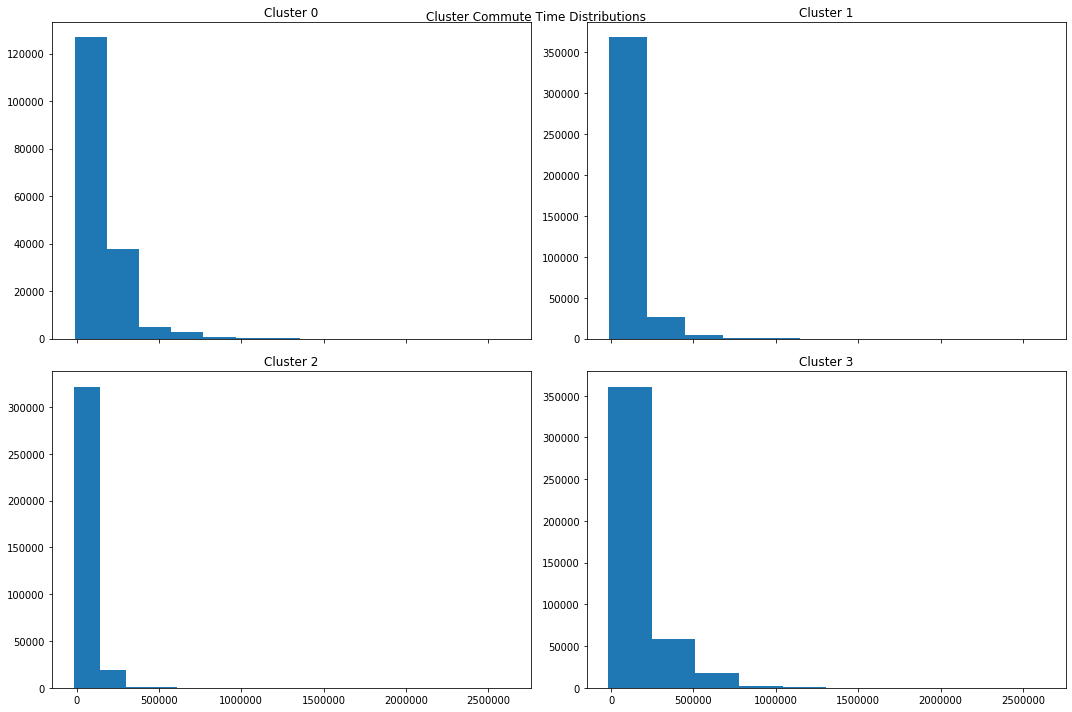

In [45]:
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(15,10))
fig.suptitle("Cluster Commute Time Distributions")

axs[0, 0].hist(clust2019_0['HHINCOME'])
axs[0, 0].set_title('Cluster 0')
axs[0, 1].hist(clust2019_1['HHINCOME'])
axs[0, 1].set_title('Cluster 1')
axs[1, 0].hist(clust2019_2['HHINCOME'])
axs[1, 0].set_title('Cluster 2')
axs[1, 1].hist(clust2019_3['HHINCOME'])
axs[1, 1].set_title('Cluster 3')

plt.tight_layout()
for ax in axs.flat[4:]:
    ax.set(xlabel='Commute Time (Minutes)')

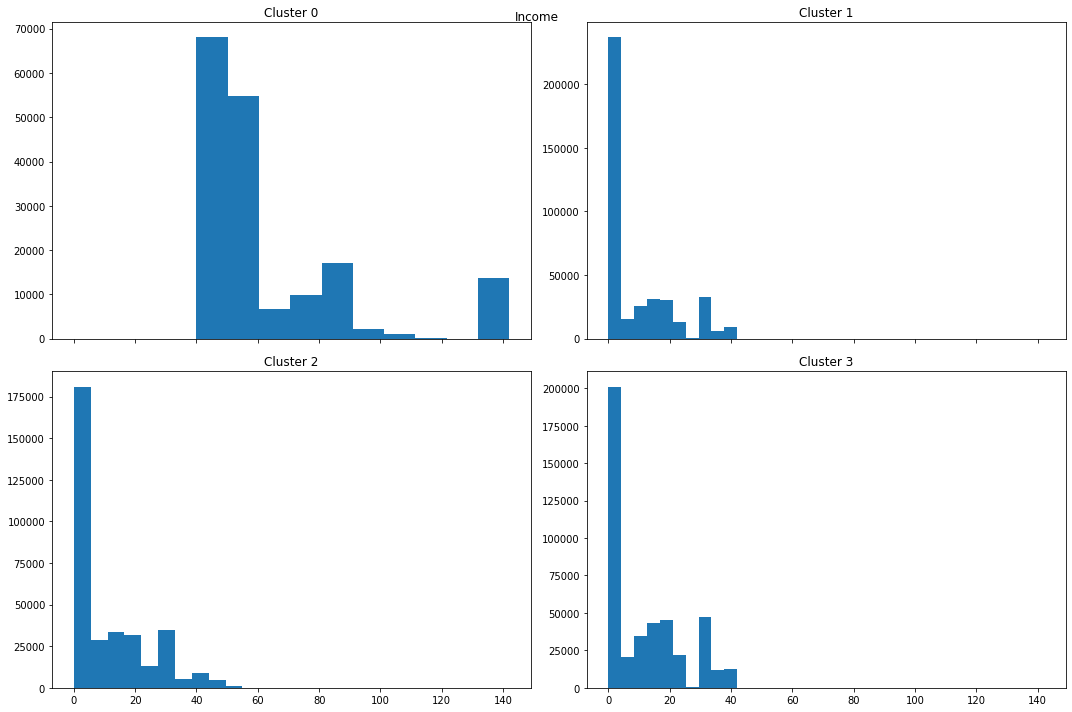

In [44]:
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(15,10))
fig.suptitle("Income")

axs[0, 0].hist(clust2019_0['TRANTIME'])
axs[0, 0].set_title('Cluster 0')
axs[0, 1].hist(clust2019_1['TRANTIME'])
axs[0, 1].set_title('Cluster 1')
axs[1, 0].hist(clust2019_2['TRANTIME'])
axs[1, 0].set_title('Cluster 2')
axs[1, 1].hist(clust2019_3['TRANTIME'])
axs[1, 1].set_title('Cluster 3')

plt.tight_layout()
for ax in axs.flat[4:]:
    ax.set(xlabel='Income')

<AxesSubplot:>

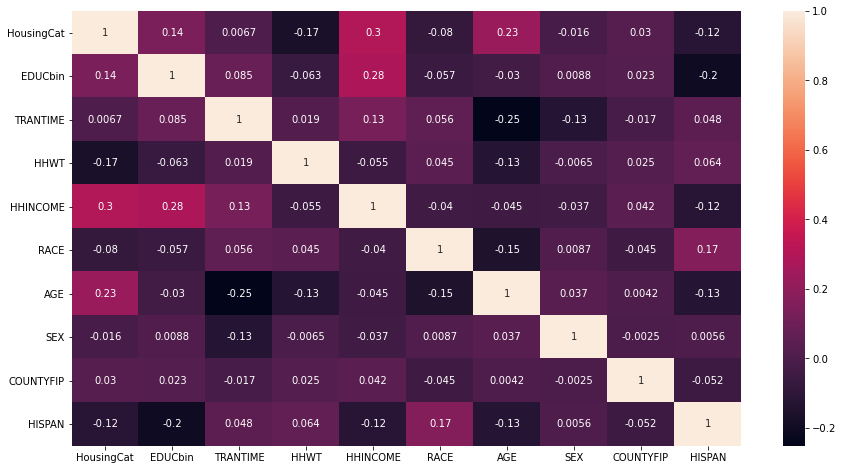

In [33]:
Xcorr19=dfX19fin.iloc[:, [0,1,2,3,4,5,6,7,8,9]]
plt.subplots(figsize=(15,8))
sns.heatmap(Xcorr19.corr(), annot = True)


### 2010

In [25]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
kmeans.fit(dfX10.iloc[:,0:3])
X10fin = scaler.inverse_transform(dfX10)
dfX10fin = pd.DataFrame(X10fin, columns=['HousingCat','EDUCbin','TRANTIME','HHWT','HHINCOME','RACE','AGE','SEX','COUNTYFIP','HISPAN'])
dfX10fin['labels'] = kmeans.labels_
cluster_sum10 = dfX10fin.groupby(by = 'labels').mean()
cluster_sum10.head(5)


,HousingCat,EDUCbin,TRANTIME,HHWT,HHINCOME,RACE,AGE,SEX,COUNTYFIP,HISPAN
labels,,,,,,,,,,
0,2.000000,0.000000,8.311891,18.186226,86534.360075,2.448684,53.102443,1.548827,53.831618,0.470251
1,1.816378,1.000000,11.849024,18.170878,136511.353001,2.262138,49.380391,1.524656,55.140022,0.193769
2,0.391211,0.145278,10.025884,22.861778,46992.433084,2.895852,43.351310,1.539566,52.248687,0.628307
3,1.616042,0.485011,64.852713,20.161208,116646.961642,2.698102,43.321468,1.388535,51.684387,0.478809


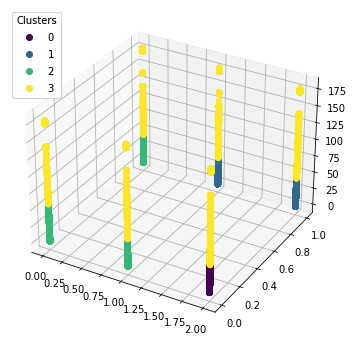

In [36]:
from mpl_toolkits.mplot3d import Axes3D
fig=plt.figure(figsize=(26,6))
ax = fig.add_subplot(131,projection='3d')
scatter = ax.scatter(dfX10fin.HousingCat,dfX10fin.EDUCbin,dfX10fin.TRANTIME,c=dfX10fin.labels,s=30)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="Clusters")
ax.add_artist(legend1)
plt.show()

<AxesSubplot:>

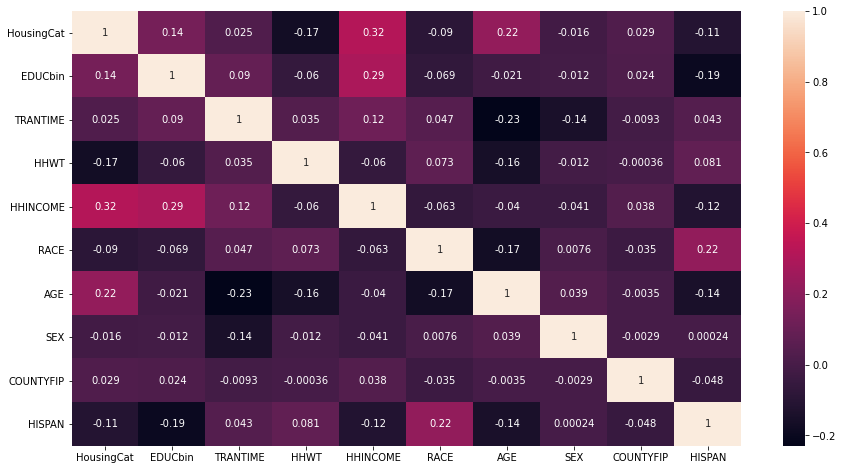

In [27]:
Xcorr10=dfX10fin.iloc[:, [0,1,2,3,4,5,6,7,8,9]]
plt.subplots(figsize=(15,8))
sns.heatmap(Xcorr10.corr(), annot = True)


### 2000

In [28]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
kmeans.fit(dfX00.iloc[:,0:3])
X00fin = scaler.inverse_transform(dfX00)
dfX00fin = pd.DataFrame(X00fin, columns=['HousingCat','EDUCbin','TRANTIME','HHWT','HHINCOME','RACE','AGE','SEX','COUNTYFIP','HISPAN'])
dfX00fin['labels'] = kmeans.labels_
cluster_sum00 = dfX00fin.groupby(by = 'labels').mean()
cluster_sum00.head(5)


,HousingCat,EDUCbin,TRANTIME,HHWT,HHINCOME,RACE,AGE,SEX,COUNTYFIP,HISPAN
labels,,,,,,,,,,
0,2.000000,0.000000,9.552195,19.452120,72501.662914,2.645157,50.562585,1.548115,52.861837,0.461594
1,1.766062,1.000000,15.008891,20.049809,110868.113690,2.202240,46.303897,1.501485,54.308015,0.171414
2,0.532048,0.095235,10.468938,20.373155,49265.692795,3.343399,40.657700,1.525789,51.699441,0.696424
3,1.549440,0.375000,80.903810,20.257028,89374.402053,2.733913,40.906761,1.370745,50.977984,0.471149


<AxesSubplot:>

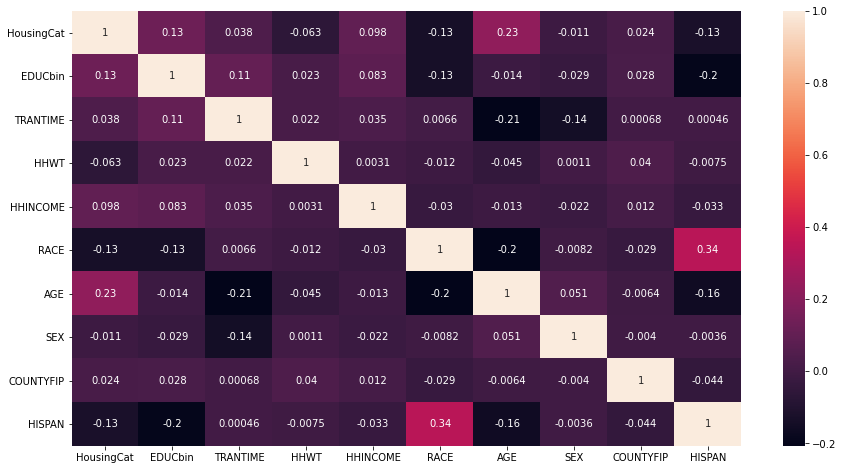

In [29]:
Xcorr00=dfX00fin.iloc[:, [0,1,2,3,4,5,6,7,8,9]]
plt.subplots(figsize=(15,8))
sns.heatmap(Xcorr00.corr(), annot = True)


### 1990

In [30]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
kmeans.fit(dfX90.iloc[:,0:3])
X90fin = scaler.inverse_transform(dfX90)
dfX90fin = pd.DataFrame(X90fin, columns=['HousingCat','EDUCbin','TRANTIME','HHWT','HHINCOME','RACE','AGE','SEX','COUNTYFIP','HISPAN'])
dfX90fin['labels'] = kmeans.labels_
cluster_sum90 = dfX90fin.groupby(by = 'labels').mean()
cluster_sum90.head(5)


,HousingCat,EDUCbin,TRANTIME,HHWT,HHINCOME,RACE,AGE,SEX,COUNTYFIP,HISPAN
labels,,,,,,,,,,
0,2.000000,0.000000,8.200154,19.382852,50344.338479,1.968691,50.362844,1.569326,52.958754,0.295185
1,1.770943,1.000000,15.426928,19.976285,71433.732782,1.765125,43.500383,1.478019,53.937945,0.146629
2,0.500794,0.093987,10.423392,21.640624,29715.600988,2.640184,39.138719,1.533481,52.118339,0.538956
3,1.602153,0.271089,59.800477,20.401737,59819.405186,2.189663,39.122303,1.352164,51.615530,0.392465


<AxesSubplot:>

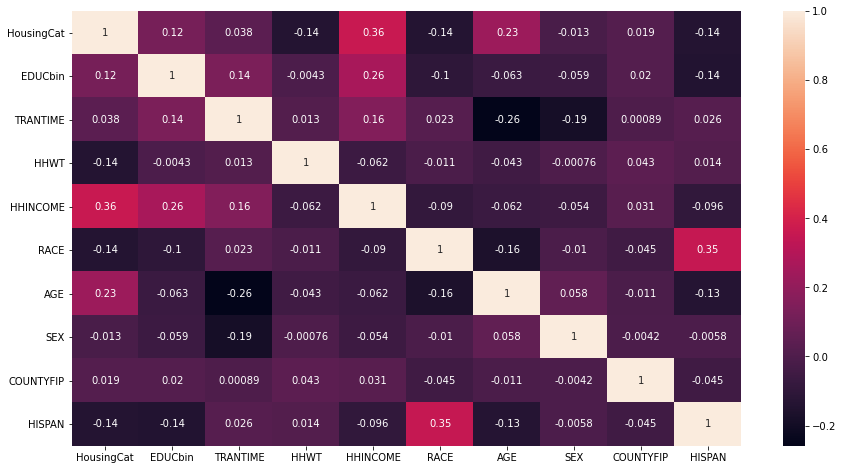

In [31]:
Xcorr90=dfX90fin.iloc[:, [0,1,2,3,4,5,6,7,8,9]]
plt.subplots(figsize=(15,8))
sns.heatmap(Xcorr90.corr(), annot = True)


## Geographic Grouping

In [38]:
#import County Geographies
import geopandas as gpd
countygeo=gpd.read_file("C:/Users/Aren Kabarajian/Documents/NYU_CUSP/Capstone/ca-county-boundaries/CA_Counties/CA_Counties_TIGER2016.shp")
countygeo.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,06,091,00277310,06091,Sierra,Sierra County,06,H1,G4020,None,None,None,A,2468694587,23299110,+39.5769252,-120.5219926,"POLYGON ((-13431319.751 4821511.426, -13431312..."
1,06,067,00277298,06067,Sacramento,Sacramento County,06,H1,G4020,472,40900,None,A,2499183617,76073827,+38.4500114,-121.3404409,"POLYGON ((-13490651.476 4680831.603, -13490511..."
2,06,083,00277306,06083,Santa Barbara,Santa Barbara County,06,H1,G4020,None,42200,None,A,7084000598,2729814515,+34.5370572,-120.0399729,"MULTIPOLYGON (((-13423116.772 4042044.149, -13..."
3,06,009,01675885,06009,Calaveras,Calaveras County,06,H1,G4020,None,None,None,A,2641820834,43806026,+38.1838996,-120.5614415,"POLYGON ((-13428575.483 4627725.228, -13428534..."
4,06,111,00277320,06111,Ventura,Ventura County,06,H1,G4020,348,37100,None,A,4773390489,945942791,+34.3587415,-119.1331432,"MULTIPOLYGON (((-13317853.594 3931602.414, -13..."


In [39]:
def GEOIDfunc(geoid):
    if len(geoid)==1:
        geoid='0600'+geoid
    elif len(geoid)==2:
        geoid='060'+geoid
    elif len(geoid)==3:
        geoid='06'+geoid
    else:
        pass
    return geoid

In [40]:
#Prepare for geographies - aggregate by cluster and FIP Code - count of persons, sum of weight
df10geo = dfX10fin[['COUNTYFIP','EDUCbin','HHWT','labels']].groupby(['COUNTYFIP','labels']).agg({'EDUCbin' : ['count'], 'HHWT' : ['sum']}).copy()


In [41]:
#Multiply by Household weight 
df10geo = (df10geo['HHWT']/df10geo['HHWT'].sum())*df10geo['EDUCbin'].values

In [42]:
#Label pop accordingly
df10geo.columns = ['Weighted_pop']

In [43]:
#reindex
df10geo.reset_index(inplace=True)

In [44]:
#format for merging
df10geo['COUNTYFIP'] = pd.Series(df10geo['COUNTYFIP'], dtype="int")
df10geo['COUNTYFIP'] = pd.Series(df10geo['COUNTYFIP'], dtype="string")
df10geo['Weighted_pop'] = pd.Series(df10geo['Weighted_pop'], dtype="int")


In [45]:
df10geo.dtypes

COUNTYFIP       string
labels           int64
Weighted_pop     int32
dtype: object

In [46]:
#add geocode formatting
df10geo['GEOID'] = df10geo.apply(lambda x: GEOIDfunc(x['COUNTYFIP']), axis=1)

In [47]:
#sort, get total pop by county, create percent variable 
df10geo = df10geo.sort_values('GEOID')
df10sum = df10geo[['Weighted_pop','GEOID']].groupby('GEOID').sum()
df10sum.columns = ['County_pop']
df10sum = df10sum.reset_index()
df10geo = df10geo.merge(df10sum,how='right')
df10geo['perc_pop'] = round(df10geo['Weighted_pop']/df10geo['County_pop'],2)
df10geo

,COUNTYFIP,labels,Weighted_pop,GEOID,County_pop,perc_pop
0,0,0,312,06000,555,0.56
1,0,1,117,06000,555,0.21
2,0,2,116,06000,555,0.21
3,0,3,10,06000,555,0.02
4,1,0,149,06001,587,0.25
...,...,...,...,...,...,...
135,111,3,5,06111,178,0.03
136,113,2,3,06113,9,0.33
137,113,0,2,06113,9,0.22
138,113,1,4,06113,9,0.44


In [48]:
#create dataframes for each cluster
cluster0_2010 = df10geo[(df10geo['labels'] == 0)]
cluster1_2010 = df10geo[(df10geo['labels'] == 1)]
cluster2_2010 = df10geo[(df10geo['labels'] == 2)]
cluster3_2010 = df10geo[(df10geo['labels'] == 3)]


In [49]:
#merge in county geography for plotting 
cluster0_2010_geo=countygeo.merge(cluster0_2010,left_index=True, right_index=True, how='left', suffixes=['','_norm'])
cluster1_2010_geo=countygeo.merge(cluster1_2010,left_index=True, right_index=True, how='left', suffixes=['','_norm'])
cluster2_2010_geo=countygeo.merge(cluster2_2010,left_index=True, right_index=True, how='left', suffixes=['','_norm'])
cluster3_2010_geo=countygeo.merge(cluster3_2010,left_index=True, right_index=True, how='left', suffixes=['','_norm'])


C:\Users\Aren Kabarajian\anaconda3\envs\geopandas_env\lib\site-packages\geopandas\plotting.py:634: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  warnings.warn(
C:\Users\Aren Kabarajian\anaconda3\envs\geopandas_env\lib\site-packages\geopandas\plotting.py:634: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  warnings.warn(
C:\Users\Aren Kabarajian\anaconda3\envs\geopandas_env\lib\site-packages\geopandas\plotting.py:634: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  warnings.warn(
C:\Users\Aren Kabarajian\anaconda3\envs\geopandas_env\lib\site-packages\geopandas\plotting.py:634: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  warnings.warn(


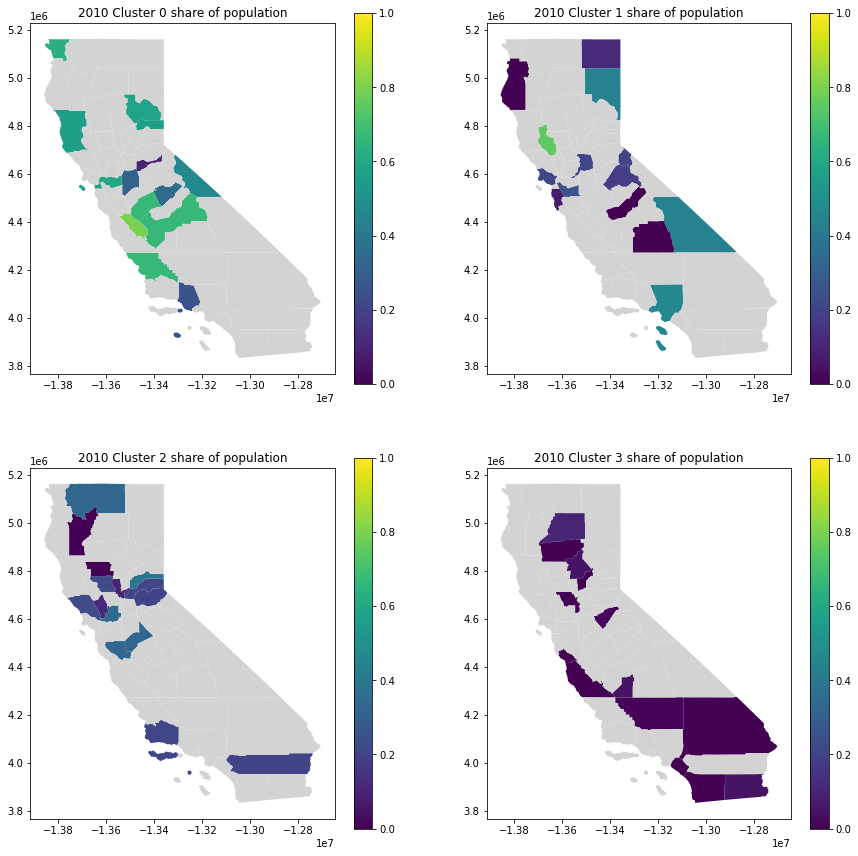

In [60]:
#plot maps - make regions with 0 % grey
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(2,2,1)
ax1 = cluster0_2010_geo.plot(axes=ax1,column="perc_pop",legend=True,missing_kwds={'color': 'lightgrey'},vmin=0,vmax=1)
plt.title('2010 Cluster 0 share of population')
ax2 = fig.add_subplot(2,2,2)
ax2 = cluster1_2010_geo.plot(axes=ax2,column="perc_pop",legend=True, missing_kwds={'color': 'lightgrey'},vmin=0,vmax=1)
plt.title('2010 Cluster 1 share of population')
ax3 = fig.add_subplot(2,2,3)
ax3 = cluster2_2010_geo.plot(axes=ax3,column="perc_pop",legend=True, missing_kwds={'color': 'lightgrey'},vmin=0,vmax=1)
plt.title('2010 Cluster 2 share of population')
ax4 = fig.add_subplot(2,2,4)
ax4 = cluster3_2010_geo.plot(axes=ax4,column="perc_pop",legend=True, missing_kwds={'color': 'lightgrey'},vmin=0,vmax=1)
plt.title('2010 Cluster 3 share of population')
plt.show()


In [62]:
#Prepare for geographies - aggregate by cluster and FIP Code - count of persons, sum of weight
df19geo = dfX19fin[['COUNTYFIP','EDUCbin','HHWT','labels']].groupby(['COUNTYFIP','labels']).agg({'EDUCbin' : ['count'], 'HHWT' : ['sum']}).copy()
#Multiply by Household weight 
df19geo = (df19geo['HHWT']/df19geo['HHWT'].sum())*df19geo['EDUCbin'].values
#Label pop accordingly
df19geo.columns = ['Weighted_pop']
#reindex
df19geo.reset_index(inplace=True)
#format for merging
df19geo['COUNTYFIP'] = pd.Series(df19geo['COUNTYFIP'], dtype="int")
df19geo['COUNTYFIP'] = pd.Series(df19geo['COUNTYFIP'], dtype="string")
df19geo['Weighted_pop'] = pd.Series(df19geo['Weighted_pop'], dtype="int")
#add geocode formatting
df19geo['GEOID'] = df19geo.apply(lambda x: GEOIDfunc(x['COUNTYFIP']), axis=1)
#sort, get total pop by county, create percent variable 
df19geo = df19geo.sort_values('GEOID')
df19sum = df19geo[['Weighted_pop','GEOID']].groupby('GEOID').sum()
df19sum.columns = ['County_pop']
df19sum = df19sum.reset_index()
df19geo = df19geo.merge(df19sum,how='right')
df19geo['perc_pop'] = round(df19geo['Weighted_pop']/df10geo['County_pop'],2)
df19geo

,COUNTYFIP,labels,Weighted_pop,GEOID,County_pop,perc_pop
0,0,0,137,06000,627,0.25
1,0,1,36,06000,627,0.06
2,0,2,9,06000,627,0.02
3,0,3,445,06000,627,0.80
4,1,0,425,06001,801,0.72
...,...,...,...,...,...,...
135,111,3,110,06111,213,0.62
136,113,2,0,06113,10,0.00
137,113,0,5,06113,10,0.56
138,113,1,1,06113,10,0.11


In [63]:
#create dataframes for each cluster
cluster0_2019 = df19geo[(df19geo['labels'] == 0)]
cluster1_2019 = df19geo[(df19geo['labels'] == 1)]
cluster2_2019 = df19geo[(df19geo['labels'] == 2)]
cluster3_2019 = df19geo[(df19geo['labels'] == 3)]


In [64]:
#merge in county geography for plotting 
cluster0_2019_geo=countygeo.merge(cluster0_2019,left_index=True, right_index=True, how='left', suffixes=['','_norm'])
cluster1_2019_geo=countygeo.merge(cluster1_2019,left_index=True, right_index=True, how='left', suffixes=['','_norm'])
cluster2_2019_geo=countygeo.merge(cluster2_2019,left_index=True, right_index=True, how='left', suffixes=['','_norm'])
cluster3_2019_geo=countygeo.merge(cluster3_2019,left_index=True, right_index=True, how='left', suffixes=['','_norm'])


C:\Users\Aren Kabarajian\anaconda3\envs\geopandas_env\lib\site-packages\geopandas\plotting.py:634: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  warnings.warn(
C:\Users\Aren Kabarajian\anaconda3\envs\geopandas_env\lib\site-packages\geopandas\plotting.py:634: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  warnings.warn(
C:\Users\Aren Kabarajian\anaconda3\envs\geopandas_env\lib\site-packages\geopandas\plotting.py:634: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  warnings.warn(
C:\Users\Aren Kabarajian\anaconda3\envs\geopandas_env\lib\site-packages\geopandas\plotting.py:634: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  warnings.warn(


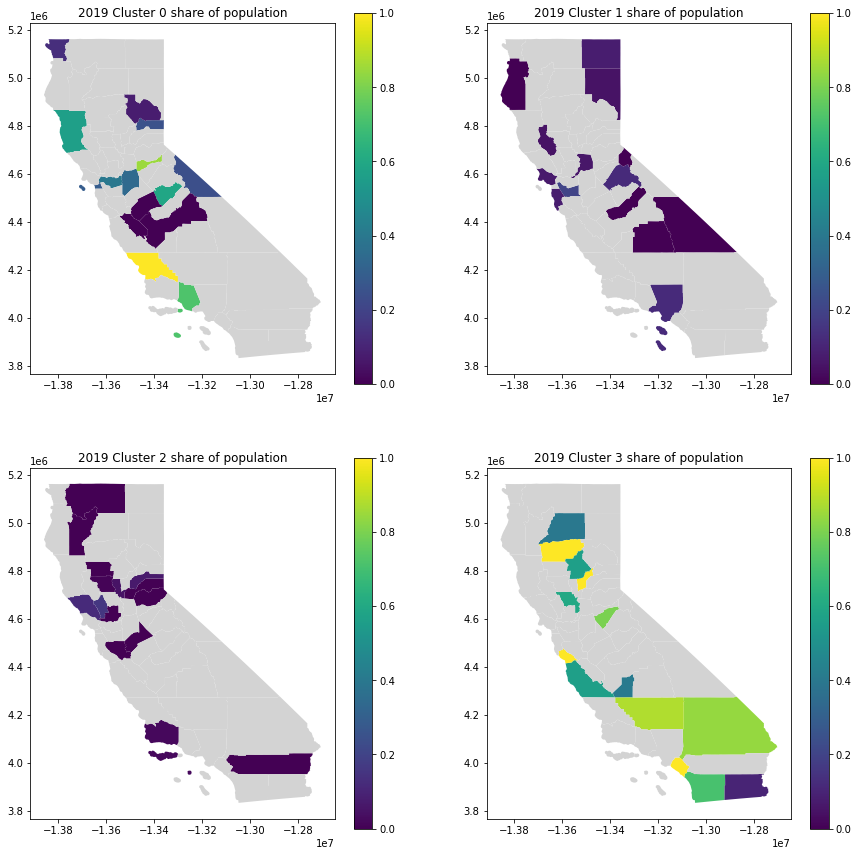

In [65]:
#plot maps - make regions with 0 % grey
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(2,2,1)
ax1 = cluster0_2019_geo.plot(axes=ax1,column="perc_pop",legend=True,missing_kwds={'color': 'lightgrey'},vmin=0,vmax=1)
plt.title('2019 Cluster 0 share of population')
ax2 = fig.add_subplot(2,2,2)
ax2 = cluster1_2019_geo.plot(axes=ax2,column="perc_pop",legend=True, missing_kwds={'color': 'lightgrey'},vmin=0,vmax=1)
plt.title('2019 Cluster 1 share of population')
ax3 = fig.add_subplot(2,2,3)
ax3 = cluster2_2019_geo.plot(axes=ax3,column="perc_pop",legend=True, missing_kwds={'color': 'lightgrey'},vmin=0,vmax=1)
plt.title('2019 Cluster 2 share of population')
ax4 = fig.add_subplot(2,2,4)
ax4 = cluster3_2019_geo.plot(axes=ax4,column="perc_pop",legend=True, missing_kwds={'color': 'lightgrey'},vmin=0,vmax=1)
plt.title('2019 Cluster 3 share of population')
plt.show()


In [66]:
#Prepare for geographies - aggregate by cluster and FIP Code - count of persons, sum of weight
df00geo = dfX00fin[['COUNTYFIP','EDUCbin','HHWT','labels']].groupby(['COUNTYFIP','labels']).agg({'EDUCbin' : ['count'], 'HHWT' : ['sum']}).copy()
#Multiply by Household weight 
df00geo = (df00geo['HHWT']/df00geo['HHWT'].sum())*df00geo['EDUCbin'].values
#Label pop accordingly
df00geo.columns = ['Weighted_pop']
#reindex
df00geo.reset_index(inplace=True)
#format for merging
df00geo['COUNTYFIP'] = pd.Series(df00geo['COUNTYFIP'], dtype="int")
df00geo['COUNTYFIP'] = pd.Series(df00geo['COUNTYFIP'], dtype="string")
df00geo['Weighted_pop'] = pd.Series(df00geo['Weighted_pop'], dtype="int")
#add geocode formatting
df00geo['GEOID'] = df00geo.apply(lambda x: GEOIDfunc(x['COUNTYFIP']), axis=1)
#sort, get total pop by county, create percent variable 
df00geo = df00geo.sort_values('GEOID')
df00sum = df00geo[['Weighted_pop','GEOID']].groupby('GEOID').sum()
df00sum.columns = ['County_pop']
df00sum = df00sum.reset_index()
df00geo = df00geo.merge(df00sum,how='right')
df00geo['perc_pop'] = round(df00geo['Weighted_pop']/df10geo['County_pop'],2)
df00geo


,COUNTYFIP,labels,Weighted_pop,GEOID,County_pop,perc_pop
0,0,0,380,06000,612,0.68
1,0,1,92,06000,612,0.17
2,0,2,135,06000,612,0.24
3,0,3,5,06000,612,0.01
4,1,0,204,06001,629,0.35
...,...,...,...,...,...,...
135,111,3,1,06111,171,0.01
136,113,2,3,06113,7,0.33
137,113,0,2,06113,7,0.22
138,113,1,2,06113,7,0.22


In [67]:
#create dataframes for each cluster
cluster0_2000 = df00geo[(df00geo['labels'] == 0)]
cluster1_2000 = df00geo[(df00geo['labels'] == 1)]
cluster2_2000 = df00geo[(df00geo['labels'] == 2)]
cluster3_2000 = df00geo[(df00geo['labels'] == 3)]


In [68]:
#merge in county geography for plotting 
cluster0_2000_geo=countygeo.merge(cluster0_2000,left_index=True, right_index=True, how='left', suffixes=['','_norm'])
cluster1_2000_geo=countygeo.merge(cluster1_2000,left_index=True, right_index=True, how='left', suffixes=['','_norm'])
cluster2_2000_geo=countygeo.merge(cluster2_2000,left_index=True, right_index=True, how='left', suffixes=['','_norm'])
cluster3_2000_geo=countygeo.merge(cluster3_2000,left_index=True, right_index=True, how='left', suffixes=['','_norm'])


C:\Users\Aren Kabarajian\anaconda3\envs\geopandas_env\lib\site-packages\geopandas\plotting.py:634: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  warnings.warn(
C:\Users\Aren Kabarajian\anaconda3\envs\geopandas_env\lib\site-packages\geopandas\plotting.py:634: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  warnings.warn(
C:\Users\Aren Kabarajian\anaconda3\envs\geopandas_env\lib\site-packages\geopandas\plotting.py:634: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  warnings.warn(
C:\Users\Aren Kabarajian\anaconda3\envs\geopandas_env\lib\site-packages\geopandas\plotting.py:634: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  warnings.warn(


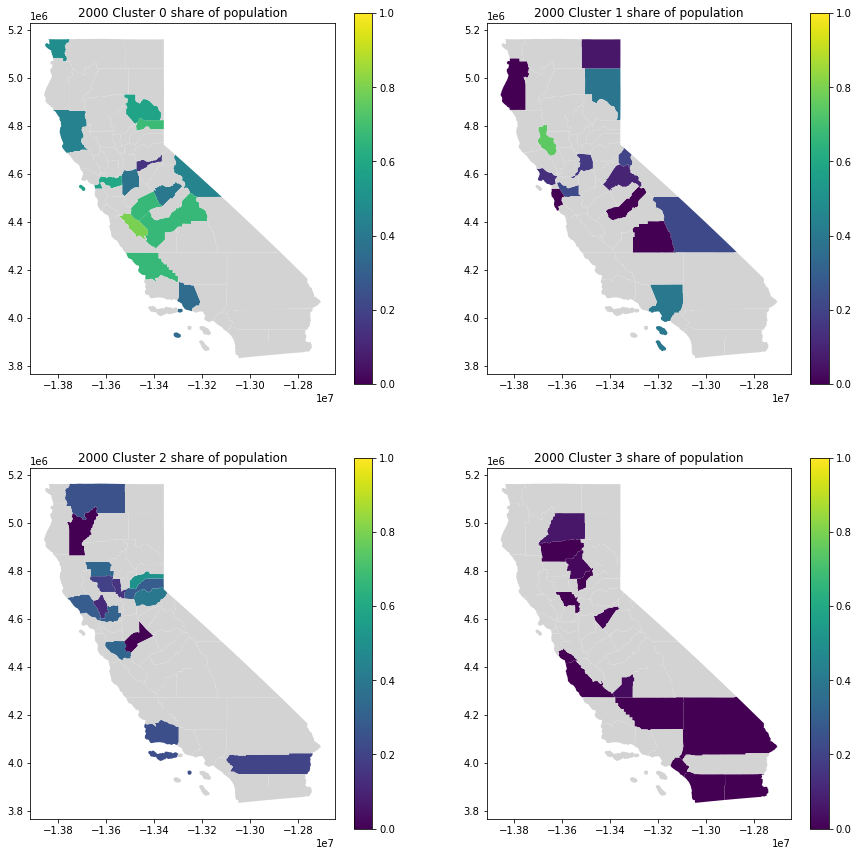

In [69]:
#plot maps - make regions with 0 % grey
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(2,2,1)
ax1 = cluster0_2000_geo.plot(axes=ax1,column="perc_pop",legend=True,missing_kwds={'color': 'lightgrey'},vmin=0,vmax=1)
plt.title('2000 Cluster 0 share of population')
ax2 = fig.add_subplot(2,2,2)
ax2 = cluster1_2000_geo.plot(axes=ax2,column="perc_pop",legend=True, missing_kwds={'color': 'lightgrey'},vmin=0,vmax=1)
plt.title('2000 Cluster 1 share of population')
ax3 = fig.add_subplot(2,2,3)
ax3 = cluster2_2000_geo.plot(axes=ax3,column="perc_pop",legend=True, missing_kwds={'color': 'lightgrey'},vmin=0,vmax=1)
plt.title('2000 Cluster 2 share of population')
ax4 = fig.add_subplot(2,2,4)
ax4 = cluster3_2000_geo.plot(axes=ax4,column="perc_pop",legend=True, missing_kwds={'color': 'lightgrey'},vmin=0,vmax=1)
plt.title('2000 Cluster 3 share of population')
plt.show()


In [70]:
#Prepare for geographies - aggregate by cluster and FIP Code - count of persons, sum of weight
df90geo = dfX90fin[['COUNTYFIP','EDUCbin','HHWT','labels']].groupby(['COUNTYFIP','labels']).agg({'EDUCbin' : ['count'], 'HHWT' : ['sum']}).copy()
#Multiply by Household weight 
df90geo = (df90geo['HHWT']/df90geo['HHWT'].sum())*df90geo['EDUCbin'].values
#Label pop accordingly
df90geo.columns = ['Weighted_pop']
#reindex
df90geo.reset_index(inplace=True)
#format for merging
df90geo['COUNTYFIP'] = pd.Series(df90geo['COUNTYFIP'], dtype="int")
df90geo['COUNTYFIP'] = pd.Series(df90geo['COUNTYFIP'], dtype="string")
df90geo['Weighted_pop'] = pd.Series(df90geo['Weighted_pop'], dtype="int")
#add geocode formatting
df90geo['GEOID'] = df90geo.apply(lambda x: GEOIDfunc(x['COUNTYFIP']), axis=1)
#sort, get total pop by county, create percent variable 
df90geo = df90geo.sort_values('GEOID')
df90sum = df90geo[['Weighted_pop','GEOID']].groupby('GEOID').sum()
df90sum.columns = ['County_pop']
df90sum = df90sum.reset_index()
df90geo = df90geo.merge(df90sum,how='right')
df90geo['perc_pop'] = round(df90geo['Weighted_pop']/df10geo['County_pop'],2)
df90geo


,COUNTYFIP,labels,Weighted_pop,GEOID,County_pop,perc_pop
0,0,0,223,06000,317,0.40
1,0,1,33,06000,317,0.06
2,0,2,58,06000,317,0.10
3,0,3,3,06000,317,0.01
4,1,0,202,06001,544,0.34
...,...,...,...,...,...,...
135,111,3,5,06111,138,0.03
136,113,2,2,06113,5,0.22
137,113,0,2,06113,5,0.22
138,113,1,1,06113,5,0.11


In [71]:
#create dataframes for each cluster
cluster0_1990 = df90geo[(df90geo['labels'] == 0)]
cluster1_1990 = df90geo[(df90geo['labels'] == 1)]
cluster2_1990 = df90geo[(df90geo['labels'] == 2)]
cluster3_1990 = df90geo[(df90geo['labels'] == 3)]


In [72]:
#merge in county geography for plotting 
cluster0_1990_geo=countygeo.merge(cluster0_1990,left_index=True, right_index=True, how='left', suffixes=['','_norm'])
cluster1_1990_geo=countygeo.merge(cluster1_1990,left_index=True, right_index=True, how='left', suffixes=['','_norm'])
cluster2_1990_geo=countygeo.merge(cluster2_1990,left_index=True, right_index=True, how='left', suffixes=['','_norm'])
cluster3_1990_geo=countygeo.merge(cluster3_1990,left_index=True, right_index=True, how='left', suffixes=['','_norm'])


C:\Users\Aren Kabarajian\anaconda3\envs\geopandas_env\lib\site-packages\geopandas\plotting.py:634: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  warnings.warn(
C:\Users\Aren Kabarajian\anaconda3\envs\geopandas_env\lib\site-packages\geopandas\plotting.py:634: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  warnings.warn(
C:\Users\Aren Kabarajian\anaconda3\envs\geopandas_env\lib\site-packages\geopandas\plotting.py:634: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  warnings.warn(
C:\Users\Aren Kabarajian\anaconda3\envs\geopandas_env\lib\site-packages\geopandas\plotting.py:634: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  warnings.warn(


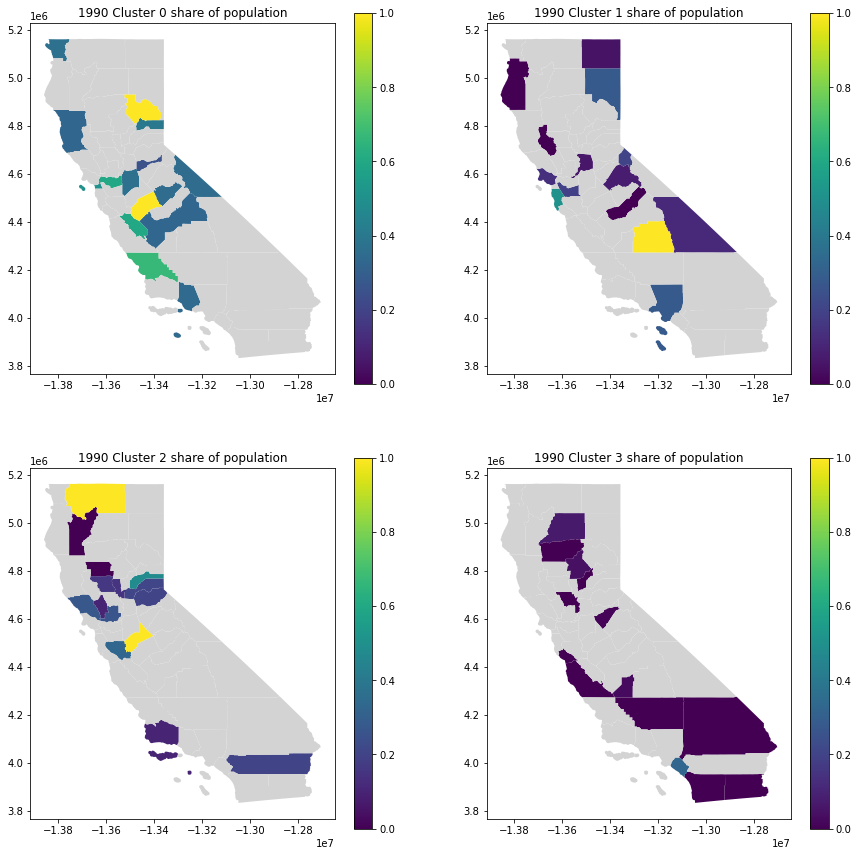

In [73]:
#plot maps - make regions with 0 % grey
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(2,2,1)
ax1 = cluster0_1990_geo.plot(axes=ax1,column="perc_pop",legend=True,missing_kwds={'color': 'lightgrey'},vmin=0,vmax=1)
plt.title('1990 Cluster 0 share of population')
ax2 = fig.add_subplot(2,2,2)
ax2 = cluster1_1990_geo.plot(axes=ax2,column="perc_pop",legend=True, missing_kwds={'color': 'lightgrey'},vmin=0,vmax=1)
plt.title('1990 Cluster 1 share of population')
ax3 = fig.add_subplot(2,2,3)
ax3 = cluster2_1990_geo.plot(axes=ax3,column="perc_pop",legend=True, missing_kwds={'color': 'lightgrey'},vmin=0,vmax=1)
plt.title('1990 Cluster 2 share of population')
ax4 = fig.add_subplot(2,2,4)
ax4 = cluster3_1990_geo.plot(axes=ax4,column="perc_pop",legend=True, missing_kwds={'color': 'lightgrey'},vmin=0,vmax=1)
plt.title('1990 Cluster 3 share of population')
plt.show()


C:\Users\Aren Kabarajian\anaconda3\envs\geopandas_env\lib\site-packages\geopandas\plotting.py:634: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  warnings.warn(
C:\Users\Aren Kabarajian\anaconda3\envs\geopandas_env\lib\site-packages\geopandas\plotting.py:634: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  warnings.warn(
C:\Users\Aren Kabarajian\anaconda3\envs\geopandas_env\lib\site-packages\geopandas\plotting.py:634: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  warnings.warn(
C:\Users\Aren Kabarajian\anaconda3\envs\geopandas_env\lib\site-packages\geopandas\plotting.py:634: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  warnings.warn(
C:\Users\Aren Kabarajian\anaconda3\envs\geopandas_env\lib\site-packages\geopandas\plotting.py:634: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consist

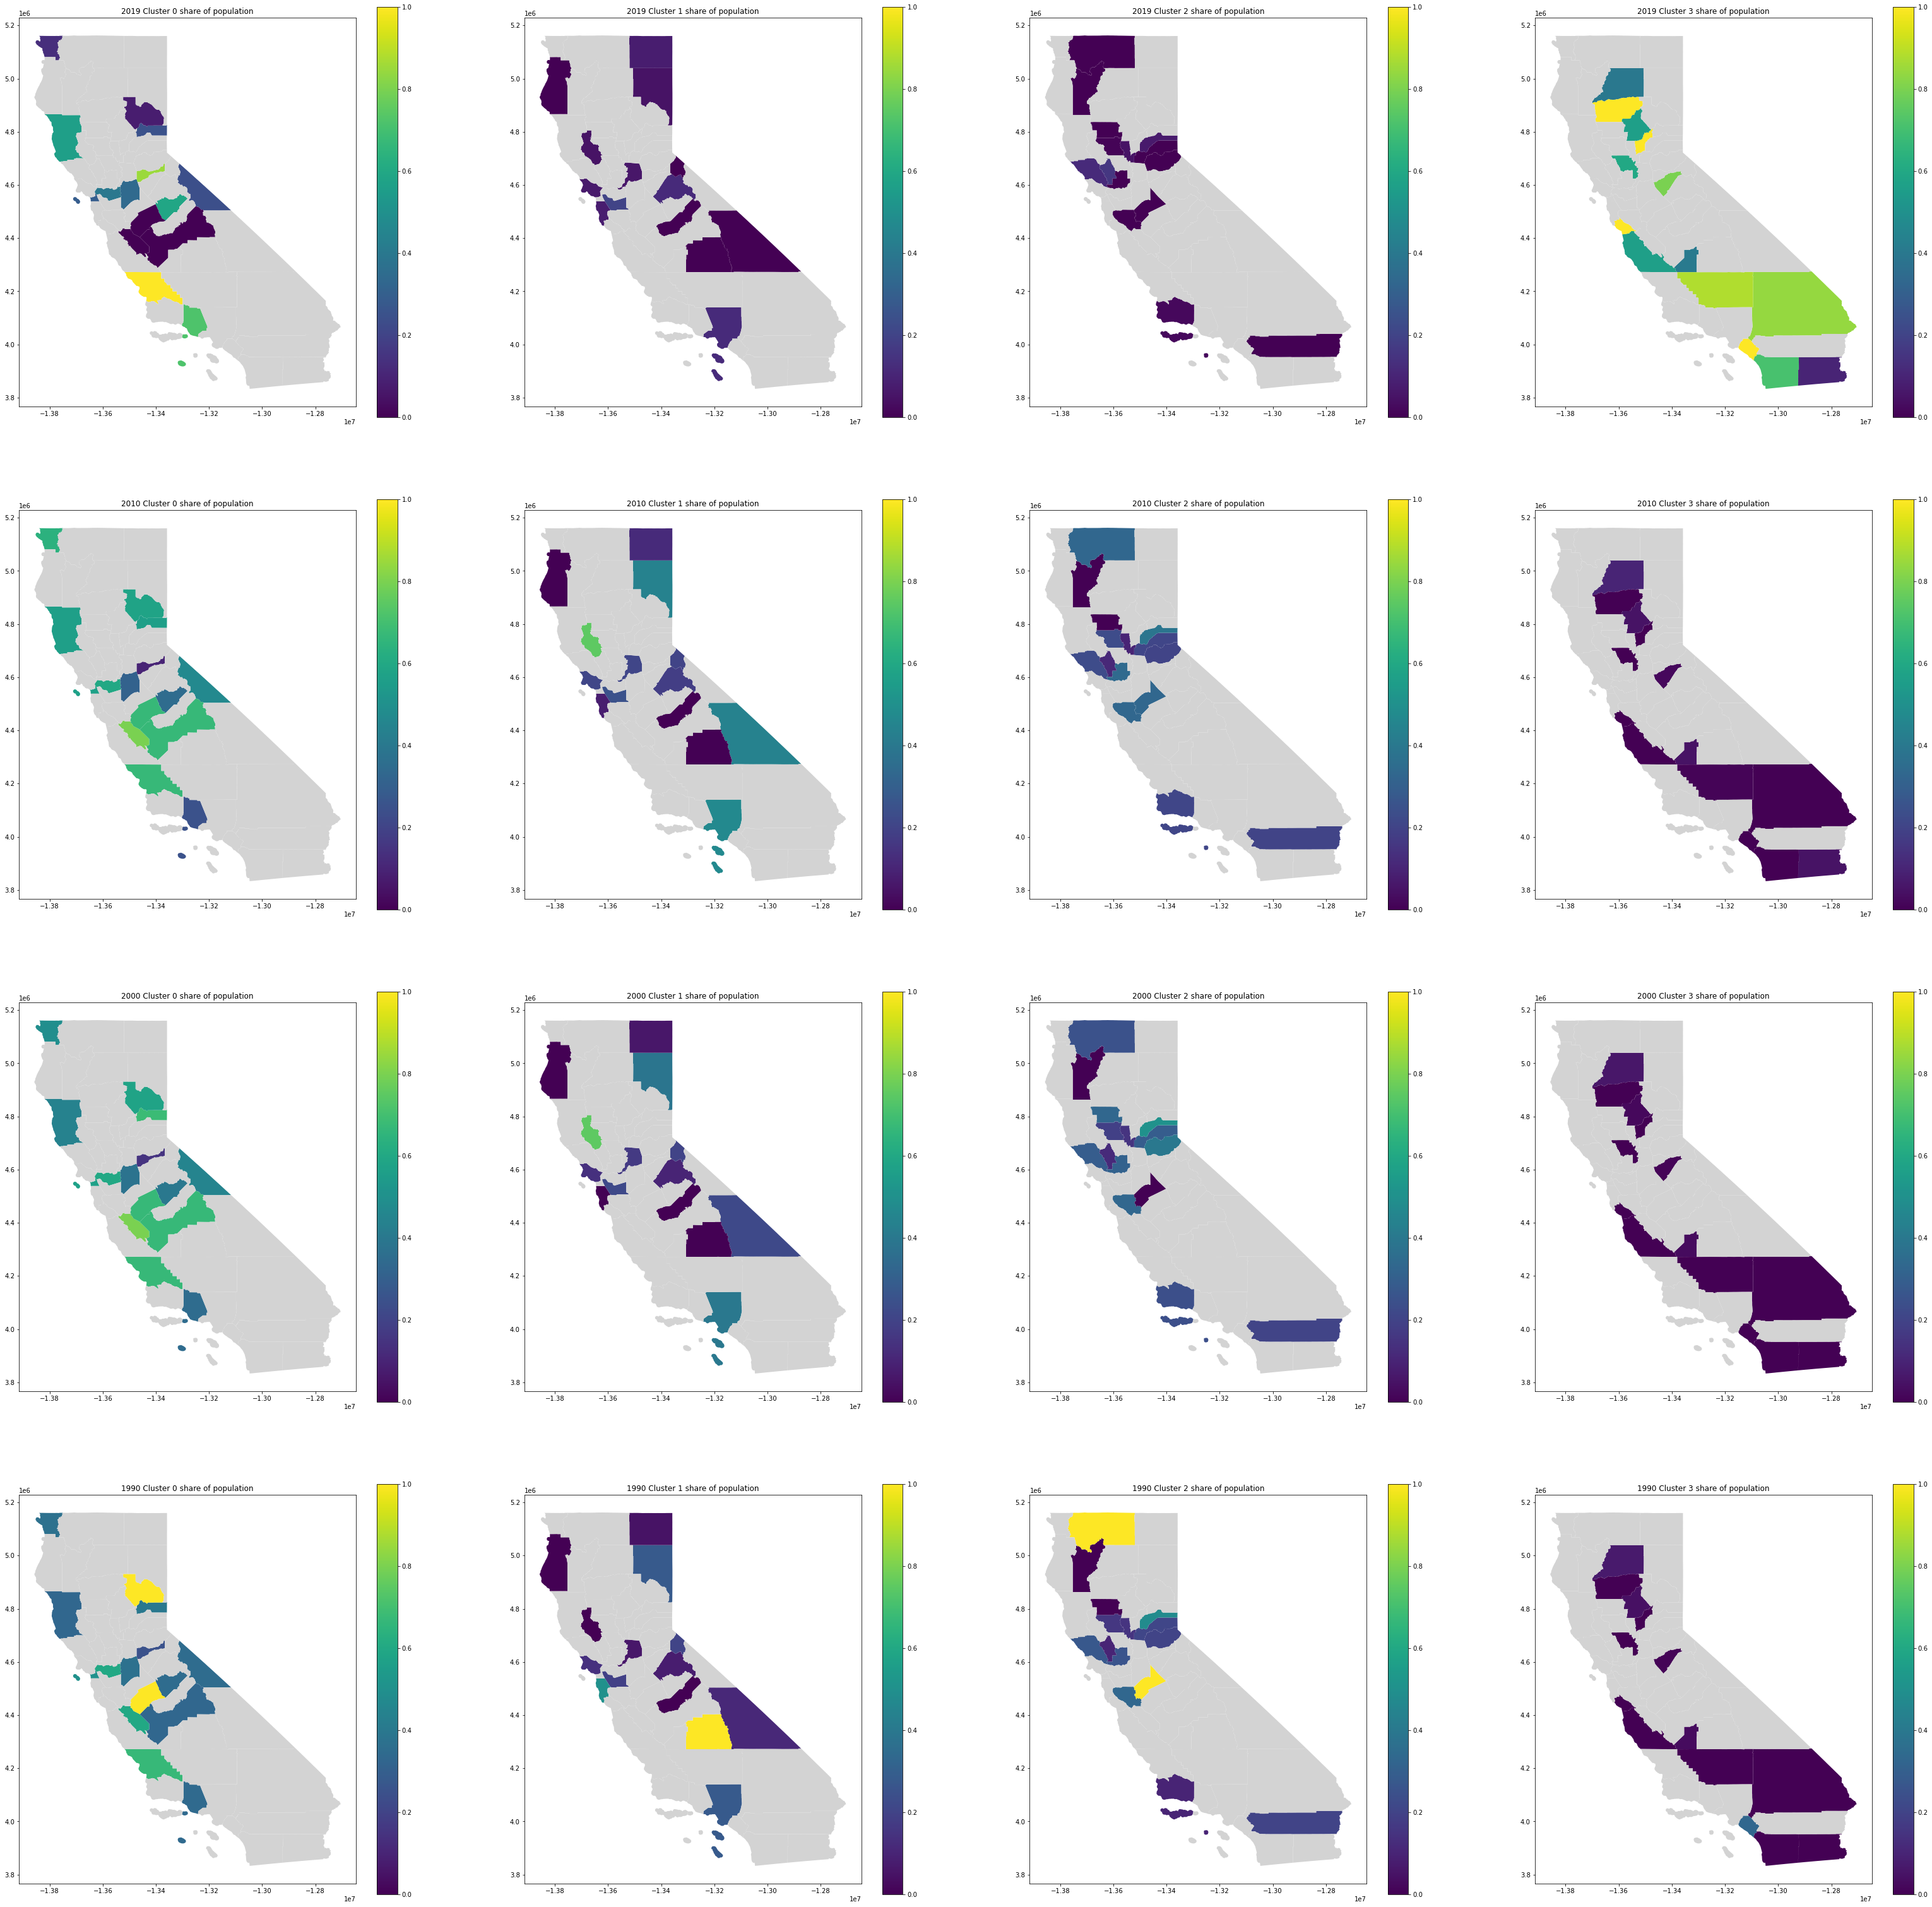

In [80]:
#plot maps - make regions with 0 % grey
fig = plt.figure(figsize=(55,55))
ax1 = fig.add_subplot(4,4,1)
ax1 = cluster0_2019_geo.plot(axes=ax1,column="perc_pop",legend=True,missing_kwds={'color': 'lightgrey'},vmin=0,vmax=1)
plt.title('2019 Cluster 0 share of population')
ax2 = fig.add_subplot(4,4,2)
ax2 = cluster1_2019_geo.plot(axes=ax2,column="perc_pop",legend=True, missing_kwds={'color': 'lightgrey'},vmin=0,vmax=1)
plt.title('2019 Cluster 1 share of population')
ax3 = fig.add_subplot(4,4,3)
ax3 = cluster2_2019_geo.plot(axes=ax3,column="perc_pop",legend=True, missing_kwds={'color': 'lightgrey'},vmin=0,vmax=1)
plt.title('2019 Cluster 2 share of population')
ax4 = fig.add_subplot(4,4,4)
ax4 = cluster3_2019_geo.plot(axes=ax4,column="perc_pop",legend=True, missing_kwds={'color': 'lightgrey'},vmin=0,vmax=1)
plt.title('2019 Cluster 3 share of population')
#plot maps - make regions with 0 % grey
#plot maps - make regions with 0 % grey
ax5 = fig.add_subplot(4,4,5)
ax5 = cluster0_2010_geo.plot(axes=ax5,column="perc_pop",legend=True,missing_kwds={'color': 'lightgrey'},vmin=0,vmax=1)
plt.title('2010 Cluster 0 share of population')
ax6 = fig.add_subplot(4,4,6)
ax6 = cluster1_2010_geo.plot(axes=ax6,column="perc_pop",legend=True, missing_kwds={'color': 'lightgrey'},vmin=0,vmax=1)
plt.title('2010 Cluster 1 share of population')
ax7 = fig.add_subplot(4,4,7)
ax7 = cluster2_2010_geo.plot(axes=ax7,column="perc_pop",legend=True, missing_kwds={'color': 'lightgrey'},vmin=0,vmax=1)
plt.title('2010 Cluster 2 share of population')
ax8 = fig.add_subplot(4,4,8)
ax8 = cluster3_2010_geo.plot(axes=ax8,column="perc_pop",legend=True, missing_kwds={'color': 'lightgrey'},vmin=0,vmax=1)
plt.title('2010 Cluster 3 share of population')
#plot maps - make regions with 0 % grey
ax9 = fig.add_subplot(4,4,9)
ax9 = cluster0_2000_geo.plot(axes=ax9,column="perc_pop",legend=True,missing_kwds={'color': 'lightgrey'},vmin=0,vmax=1)
plt.title('2000 Cluster 0 share of population')
ax10 = fig.add_subplot(4,4,10)
ax10 = cluster1_2000_geo.plot(axes=ax10,column="perc_pop",legend=True, missing_kwds={'color': 'lightgrey'},vmin=0,vmax=1)
plt.title('2000 Cluster 1 share of population')
ax11 = fig.add_subplot(4,4,11)
ax11 = cluster2_2000_geo.plot(axes=ax11,column="perc_pop",legend=True, missing_kwds={'color': 'lightgrey'},vmin=0,vmax=1)
plt.title('2000 Cluster 2 share of population')
ax12 = fig.add_subplot(4,4,12)
ax12 = cluster3_2000_geo.plot(axes=ax12,column="perc_pop",legend=True, missing_kwds={'color': 'lightgrey'},vmin=0,vmax=1)
plt.title('2000 Cluster 3 share of population')
#plot maps - make regions with 0 % grey
ax13 = fig.add_subplot(4,4,13)
ax13 = cluster0_1990_geo.plot(axes=ax13,column="perc_pop",legend=True,missing_kwds={'color': 'lightgrey'},vmin=0,vmax=1)
plt.title('1990 Cluster 0 share of population')
ax14 = fig.add_subplot(4,4,14)
ax14 = cluster1_1990_geo.plot(axes=ax14,column="perc_pop",legend=True, missing_kwds={'color': 'lightgrey'},vmin=0,vmax=1)
plt.title('1990 Cluster 1 share of population')
ax15 = fig.add_subplot(4,4,15)
ax15 = cluster2_1990_geo.plot(axes=ax15,column="perc_pop",legend=True, missing_kwds={'color': 'lightgrey'},vmin=0,vmax=1)
plt.title('1990 Cluster 2 share of population')
ax16 = fig.add_subplot(4,4,16)
ax16 = cluster3_1990_geo.plot(axes=ax16,column="perc_pop",legend=True, missing_kwds={'color': 'lightgrey'},vmin=0,vmax=1)
plt.title('1990 Cluster 3 share of population')
plt.show()
